In [1]:
import os, torch, cv2
import numpy as np
from tqdm import tqdm
from scipy import ndimage

from utils.dataloader import get_preprocessing
from utils.config import load_wdb_config, load_setting
from utils.network import Litsmp
from utils.plot import visualize
from inference import modelsetting

/home/u7085556/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/u7085556/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def connectTH(mask, map, mode=1, threshold=150):
    # identify pixel connected size
    pgroup, Nlabels = ndimage.measurements.label(map)
    label_size = [(pgroup == label).sum() for label in range(Nlabels + 1)]
    # remove those above a threshold
    mode ^= 1
    for label,size in enumerate(label_size):
        if size < threshold:
            mask[pgroup == label] = mode

In [3]:
pretrain_path = './result/U+_nc_moreaug_FTL/'
opts_dict, model = modelsetting(pretrain_path)
ds_dict = load_setting()
Public_Image = ds_dict['public_root']
preprocess = get_preprocessing()
THRESHOLD = 0.75

In [ ]:
model.eval()
height = opts_dict['aug']['resize_height']
width = height * 2
imagePaths = [image_id for image_id in os.listdir(Public_Image)]
for image_id in tqdm(imagePaths):
    image = cv2.imread(os.path.join(Public_Image, image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    origin_h, origin_w, _ = image.shape
    if image.shape != (height, width, 3):
        image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LANCZOS4)
    image = preprocess(image=image)['image']
    image = image.unsqueeze(0)
    with torch.no_grad():
        mask = torch.sigmoid(model(image)).squeeze().cpu().numpy()
    mask = cv2.resize(mask, (origin_w, origin_h), interpolation=cv2.INTER_LANCZOS4)
    mask = np.where(mask > THRESHOLD, 1, 0)
    origin = np.sum(mask == 1)

    connectTH(mask, mask, mode=1, threshold=500)
    connectTH(mask, mask^1, mode=0, threshold=500)
    
    process = np.sum(mask == 1)
    print(origin, process)

In [ ]:
# find the smallest connectTH in trainset
imagePaths = ds_dict['dataset_root']
maskPaths = os.path.join(imagePaths, 'Train_Masks')
mincp = 2000

for image_id in os.listdir(maskPaths):
    mask = cv2.imread(os.path.join(maskPaths, image_id), 0)
    pgroup, Nlabels = ndimage.measurements.label(mask)
    for label in range(Nlabels + 1):
        label_size = (pgroup == label).sum()
        if label_size < mincp:
            mincp = label_size
            print(image_id, mincp)

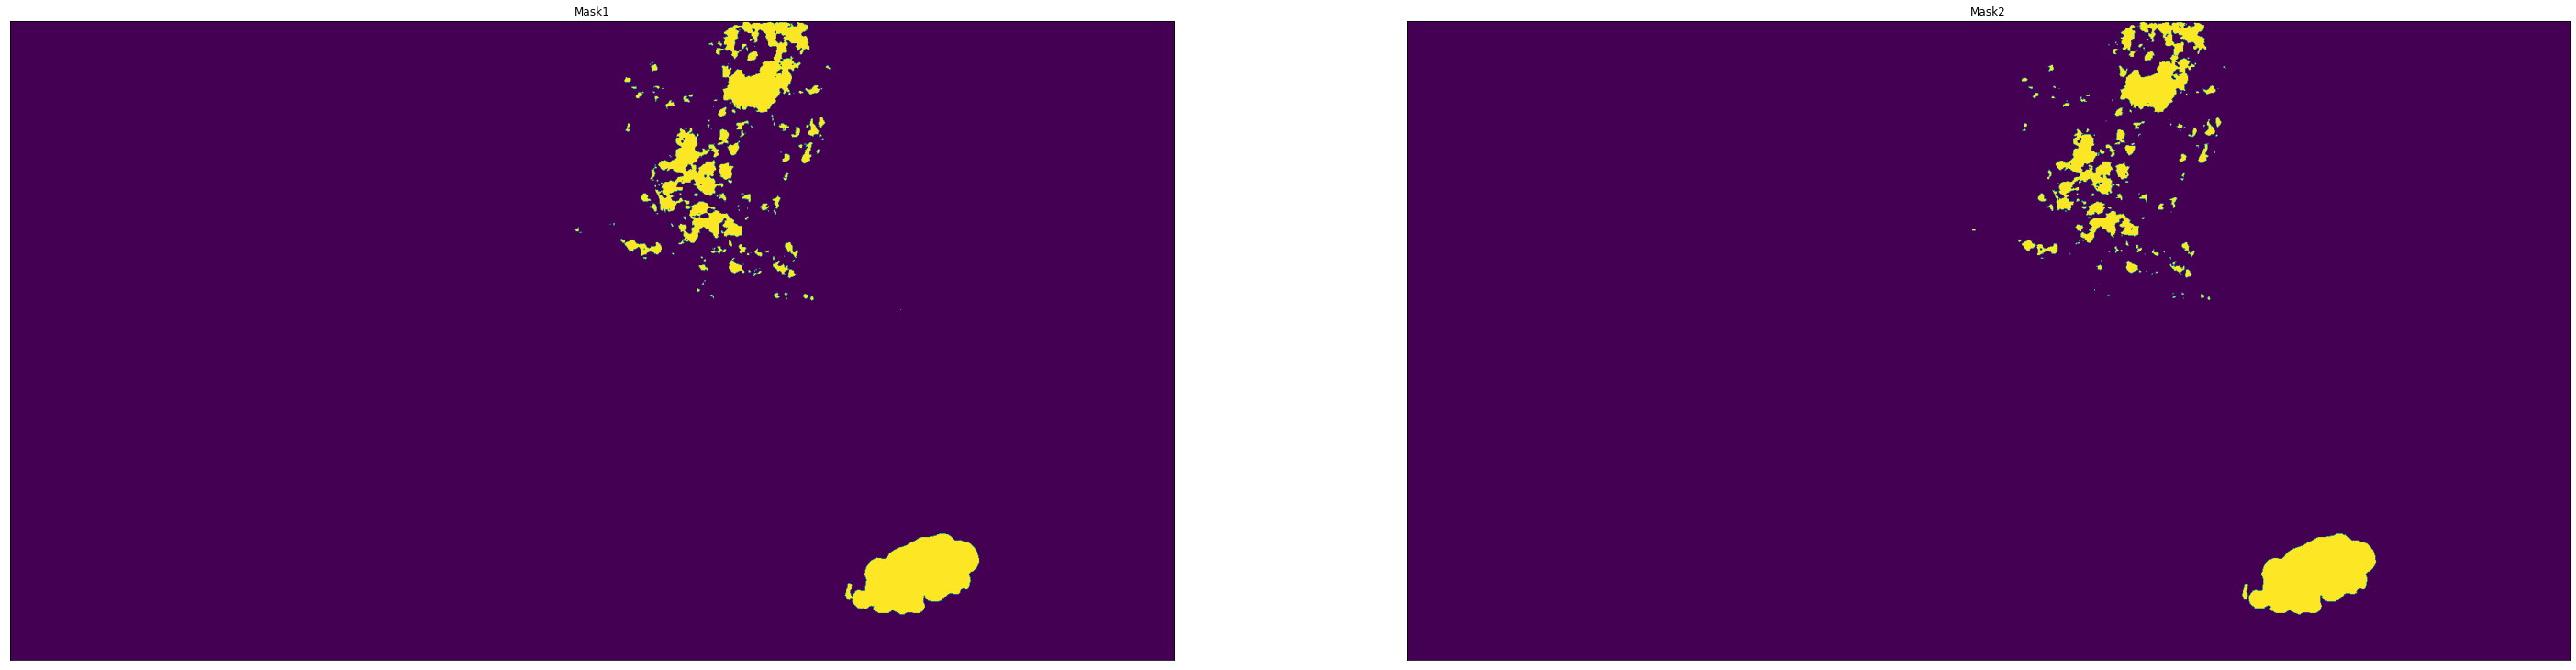

In [25]:
THRESHOLD = 0.75

model.eval()
height = opts_dict['aug']['resize_height']
width = height * 2

image = cv2.imread(os.path.join(Public_Image, 'Public_00000064.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
origin_h, origin_w, _ = image.shape
if image.shape != (height, width, 3):
    image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LANCZOS4)
image = preprocess(image=image)['image']
image = image.unsqueeze(0)
with torch.no_grad():
    mask = torch.sigmoid(model(image)).squeeze().cpu().numpy()

mask = cv2.resize(mask, (origin_w, origin_h), interpolation=cv2.INTER_LANCZOS4)
mask1 = np.where(mask > 0.75, 1, 0)
mask2 = np.where(mask > 0.85, 1, 0)
# mask3 = np.where(mask > 0.95, 1, 0)
# connectTH(mask, mask, mode=1, threshold=500)
# connectTH(mask, mask^1, mode=0, threshold=500)

visualize(
    mask1=mask1.squeeze(),
    mask2=mask2.squeeze(),
#     mask3=mask3.squeeze(),
)